#Processo de modelagem dos dados.

O processo consiste em:

- 0) Fazer todo o processo de limpeza e avaliação da base, EDA, etc., etc.


- 1) Importar a **classe do algoritmo que se deseja treinar**
    - Usaremos quase sempre a biblioteca [scikit-learn](https://scikit-learn.org/stable/)
    
  
- 2) Instanciar a classe do algoritmo, **escolhendo os hiperparâmetros desejados**
    - Para a primeira versão do modelo, pode ser uma boa escolha utilizar os parâmetros default;
    - Veremos mais pra frente como escolher os parâmetros adequadamente;
    
   
- 3) Separe os dados em **dados de treino** e **dados de teste**.
    - Em alguns casos, pode ser interessante criar também um conjunto de **dados de validação**
    - Para fazer a separação, usamos o [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    
    
- 4) Treine o modelo, usando **os dados de treino**


- 5) Use o modelo treinado para **fazer previsões** usando os **dados de teste** (ou **de validação**)


- 6) **Avalie a performance do modelo com base nas previsões acima**


- 7) Se necessário, reinicie o ciclo!


- 8) Quando o modelo estiver suficientemente bom, faça o **deploy**

#0 - Importando e instalando as bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import re
from seaborn.widgets import cubehelix_palette
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pprint import pprint
from sklearn.model_selection import GridSearchCV


In [2]:
#Paleta de cores escolhida
paleta = sns.cubehelix_palette()

#1 - Processando os dados

In [3]:
#Importando dados feito o tratamento de nulos, inconsistência de dados, união das bases e mudança de nome.
bd_data_clean = './Credit_card_clean.csv'

df = pd.read_csv(bd_data_clean)

In [4]:
#Observando as primeiras linhas dos dados
df.head().T

,0,1,2,3,4
id,5008827,5009744,5009746,5009749,5009752
genero,M,F,F,F,F
carro,Y,Y,Y,Y,Y
bens_propriedade,Y,N,N,N,N
filhos,0,0,0,0,0
renda_anual,180000.0,315000.0,315000.0,172243.04,315000.0
tipo_renda,Pensionista,Associado Comercial,Associado Comercial,Associado Comercial,Associado Comercial
escolaridade,Ensino superior,Ensino superior,Ensino superior,Ensino superior,Ensino superior
estado_civil,Casado,Casado,Casado,Casado,Casado
estilo_vida,Casa/Apartamento,Casa/Apartamento,Casa/Apartamento,Casa/Apartamento,Casa/Apartamento


In [5]:
# Algumas métricas estatísticas.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1541.0,5.078979e+06,41671.365842,5008827.0,5045113.0,5078924.0,5115671.0,5150412.0
filhos,1541.0,4.133679e-01,0.777811,0.0,0.0,0.0,1.0,14.0
renda_anual,1541.0,1.908141e+05,112153.974398,33750.0,121500.0,171000.0,225000.0,1575000.0
contar_aniverisario,1519.0,-1.604791e+04,4228.635700,-24946.0,-19561.5,-15702.0,-12417.5,-7705.0
desempregado,1541.0,5.940589e+04,137847.216798,-14887.0,-3173.0,-1563.0,-431.0,365243.0
celular,1541.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0
telefone_comercial,1541.0,2.083063e-01,0.406229,0.0,0.0,0.0,0.0,1.0
telefone,1541.0,3.082414e-01,0.461917,0.0,0.0,0.0,1.0,1.0
email_id,1541.0,9.214796e-02,0.289329,0.0,0.0,0.0,0.0,1.0
tamanho_familia,1541.0,2.162232e+00,0.948492,1.0,2.0,2.0,3.0,15.0


In [6]:
# Observando os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1541 non-null   int64  
 1   genero               1541 non-null   object 
 2   carro                1541 non-null   object 
 3   bens_propriedade     1541 non-null   object 
 4   filhos               1541 non-null   int64  
 5   renda_anual          1541 non-null   float64
 6   tipo_renda           1541 non-null   object 
 7   escolaridade         1541 non-null   object 
 8   estado_civil         1541 non-null   object 
 9   estilo_vida          1541 non-null   object 
 10  contar_aniverisario  1519 non-null   float64
 11  desempregado         1541 non-null   int64  
 12  celular              1541 non-null   int64  
 13  telefone_comercial   1541 non-null   int64  
 14  telefone             1541 non-null   int64  
 15  email_id             1541 non-null   i

#2 - Tratamento para usar os modelos de Machine Learning

In [7]:
# Definindo a media para aplicar nos nulos na coluna "contar_aniversario"
cols_media = ['contar_aniverisario']
fill_media = SimpleImputer(missing_values=np.nan, strategy='mean')
fill_media.fit(df[cols_media])
df[cols_media] = fill_media.transform(df[cols_media])

In [8]:
# contar_aniverisario tranformando em idade e excluindo coluna
df["idade"] = df["contar_aniverisario"].apply(lambda x: abs(int(x))/365)
df = df.drop("contar_aniverisario", axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1541 non-null   int64  
 1   genero              1541 non-null   object 
 2   carro               1541 non-null   object 
 3   bens_propriedade    1541 non-null   object 
 4   filhos              1541 non-null   int64  
 5   renda_anual         1541 non-null   float64
 6   tipo_renda          1541 non-null   object 
 7   escolaridade        1541 non-null   object 
 8   estado_civil        1541 non-null   object 
 9   estilo_vida         1541 non-null   object 
 10  desempregado        1541 non-null   int64  
 11  celular             1541 non-null   int64  
 12  telefone_comercial  1541 non-null   int64  
 13  telefone            1541 non-null   int64  
 14  email_id            1541 non-null   int64  
 15  tipo_ocupação       1541 non-null   object 
 16  tamanh



## Transforme as colunas categóricas

 Temos as seguintes colunas categóricas:

 genero                 
 carro               
 bens_propriedade     
 tipo_renda          
 escolaridade          
 estado_civil         
 estilo_vida         
 tipo_ocupação


 Escolhemos tratar as colunas genero, carro e bens_propriedade com Label e as colunas escolaridade, estado_civil, estilo_vida, tipo_ocupação, tipo_renda com Dummies.

 Nas colunas com tratamento tipo Dummies existiam varias opções dentro da mesma coluna e com esse tratamento dividiu as colunas contendo 0 para o caso de não condizer com a informação e 1 para o caso de condizer a informação.

 Nos tratamentos com Label foi trocada a informação para as seguintes informações:

 Y = 1;
 N = 0;
 M = 1;
 F = 0;


In [10]:
colunas_label_encoder = ['genero', 'carro', 'bens_propriedade'] #Lista de colunas que serão codificadas com Label Encoder

df_tratado = df.copy()

#Tratamento com Label Encoder
label_encoder = LabelEncoder()
for coluna in colunas_label_encoder:
    df_tratado[coluna] = label_encoder.fit_transform(df_tratado[coluna])

 #Tratamento com Dummies/One Hot Encoding
df_tratado = pd.get_dummies(df_tratado, prefix_sep='_',columns=['tipo_renda',
                                                                'escolaridade',
                                                                'estado_civil',
                                                                'estilo_vida',
                                                                'tipo_ocupação'])
df_tratado.head().T

,0,1,2,3,4
id,5008827,5009744,5009746,5009749,5009752
genero,1,0,0,0,0
carro,1,1,1,1,1
bens_propriedade,1,0,0,0,0
filhos,0,0,0,0,0
renda_anual,180000.0,315000.0,315000.0,172243.04,315000.0
desempregado,365243,-586,-586,-586,-586
celular,1,1,1,1,1
telefone_comercial,0,1,1,1,1
telefone,0,1,1,1,1


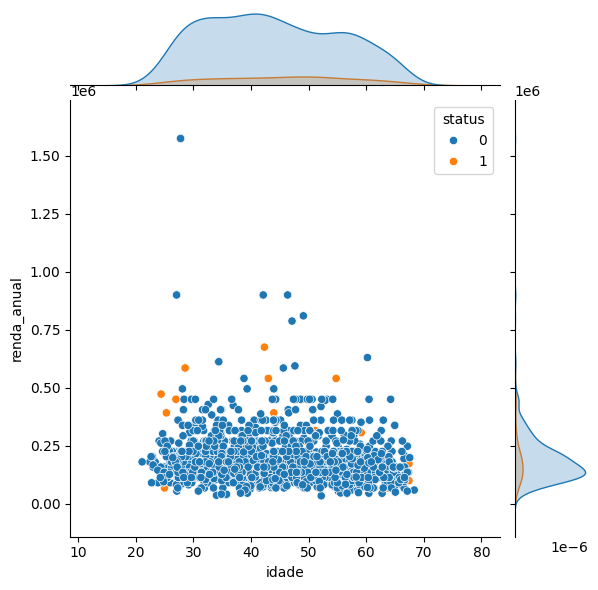

In [11]:
sns.jointplot(data=df, x='idade', y='renda_anual', hue='status')

c:\Users\gabya\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


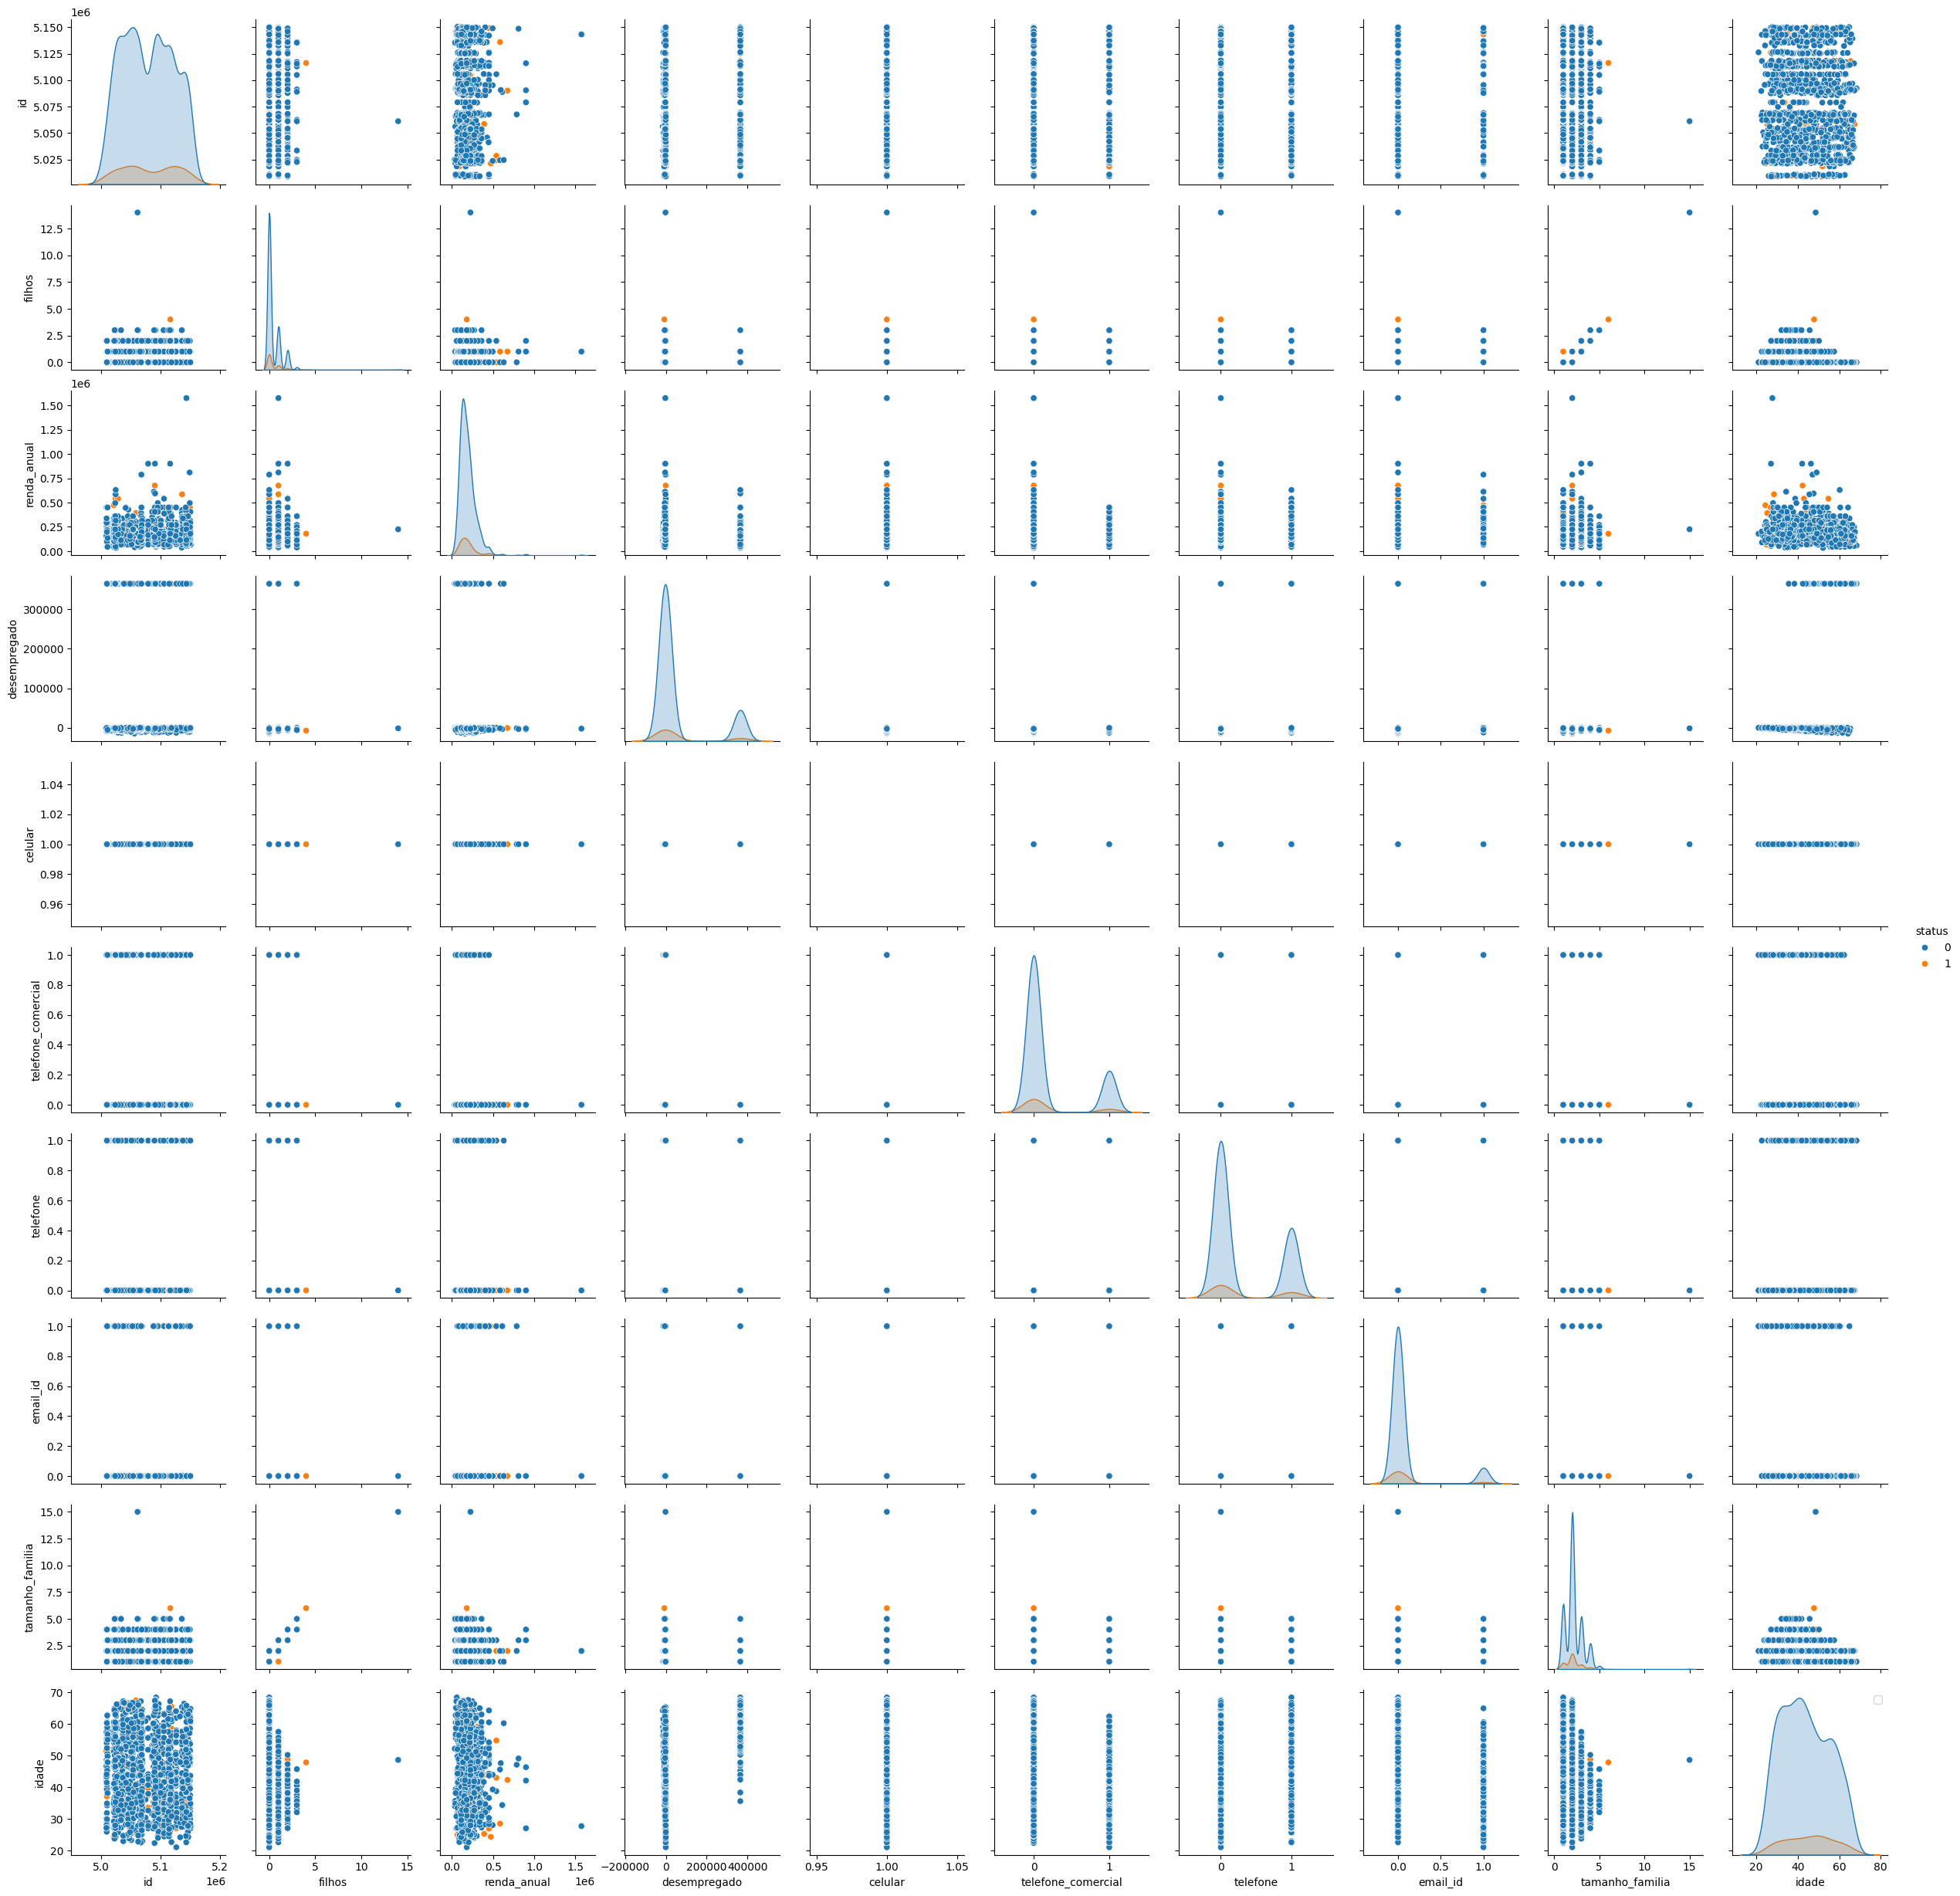

In [12]:
#Gráfico de matriz de dispersão (pair plot)
sns.pairplot(df, hue='status')
plt.legend()

#3 - Separação e normalização dos dados

In [13]:
# Remova a coluna status dos dados, extraindo as features na variável X
X = df_tratado.drop(['status'], axis = 1)
y_status = df['status']

In [14]:
#Separando em train e test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, # Conjunto de features
                                                    y_status, # Conjunto alvo
                                                    test_size=0.3, # Dividir o conjunto em x% para teste (se for float), x elementos para teste se inteiro
                                                    random_state=42, # Garantir a reprodutibilidade
                                                    stratify = y_status) # Garantir a estratificação balanceada (manter o desbalanceamento do dataset)

In [15]:
#confirmando o mantimento da proporcionalidade
print(f" Proporção y_status: \n{y_status.value_counts(normalize=True)}")
print(f" Proporção y_train: \n{y_train.value_counts(normalize=True)}")
print(f" Proporção y_test: \n{y_test.value_counts(normalize=True)}")

 Proporção y_status: 
status
0    0.889682
1    0.110318
Name: proportion, dtype: float64
 Proporção y_train: 
status
0    0.88961
1    0.11039
Name: proportion, dtype: float64
 Proporção y_test: 
status
0    0.889849
1    0.110151
Name: proportion, dtype: float64


In [16]:
# Padronização/Normalizando dos dados utilizando o StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train) #Normalização nos dados de treino

In [17]:
X_test_std = scaler.transform(X_test) #Normalização nos dados de teste

In [18]:
print('Dados de treino->', X_train.shape[0])
print('Dados de teste ->', X_test.shape[0])

Dados de treino-> 1078
Dados de teste -> 463


#4 - Machine Learning
Analisando a performace dos dados nos seguintes modelos:
- Decision Tree
- Random Forest
- AdaBoost
- Gradient Boosting
- XGBoost
- LightGBM

Para analisar esses modelos iremos utilizar as seguintes metricas:
- Acurácia
- Precisão
- Recall
- F1-Score
- ROC-AUC

In [19]:
def treinamento_modelo(estimador, X_train, X_test, y_train):
    """
    Treina um modelo com os dados de treinamento e faz previsões com os dados de teste.

    Args:
        estimador: Um modelo de aprendizado de máquina (classificador/regressor).
        X_train: Dados de treinamento.
        X_test: Dados de teste.
        y_train: Rótulos de treinamento.

    Returns:
        y_pred: Rótulos previstos pelo modelo.
    """
    estimador.fit(X_train, y_train)
    y_pred = estimador.predict(X_test)

    return y_pred


In [20]:
def analise_relatorio_matriz_confusao(lista_modelos, X_train, X_test, y_train, y_test):
    """
    Esta função treina modelos, gera relatórios de classificação e plota matrizes de confusão para cada modelo.

    Args:
        lista_modelos: Uma lista de dicionários com informações sobre os modelos.
        X_train: Dados de treinamento.
        X_test: Dados de teste.
        y_train: Rótulos de treinamento.
        y_test: Rótulos de teste.
    """

    print(f"\n\n\n **** RELATÓRIO DOS MODELOS + MATRIZ DE CONFUSÃO ****\n")

    for mdl in lista_modelos:
        nome_do_modelo = mdl["nome_do_modelo"]
        estimador = mdl["estimador"]

        y_pred = treinamento_modelo(estimador, X_train, X_test, y_train)

        report = classification_report(y_test, y_pred) #Geração dos relatórios de classificação
        print(f"Relatório de classificação para {nome_do_modelo}:\n{report}\n {'='*60}")

        #Calculando e plotando a matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(conf_mat=cm)
        plt.title(f"Matriz de Confusão para {nome_do_modelo}")
        plt.show()

In [21]:
def analise_curva_ROC_AUC(lista_modelos, X_train, X_test, y_train, y_test):
    """
    Esta função treina vários modelos e avalia seu desempenho usando métricas como acurácia, precisão, revocação e F1-score.
    Também plota a curva ROC-AUC e a matriz de confusão para cada modelo.

    Args:
        lista_modelos: Uma lista de dicionários contendo informações sobre os modelos a serem treinados.
        X_train: Dados de treinamento.
        X_test: Dados de teste.
        y_train: Rótulos de treinamento.
        y_test: Rótulos de teste.

    Returns:
        dict: Um dicionário com as métricas de desempenho de cada modelo.
    """

    print(f"\n\n\n **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****\n")

    resposta = {}

    for mdl in lista_modelos:
        nome_do_modelo = mdl["nome_do_modelo"]
        estimador = mdl.get('estimador')

        y_pred = treinamento_modelo(estimador, X_train, X_test, y_train)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, estimador.predict_proba(X_test)[:,1]) #Calculo da curva ROC

        # Cálculo das métricas de desempenho
        model_name = mdl.get('nome_do_modelo')
        accuracy = metrics.accuracy_score(y_test, y_pred)
        auc = metrics.roc_auc_score(y_test, estimador.predict(X_test))
        precision = metrics.precision_score(y_test, y_pred, average='weighted')
        recall = metrics.recall_score(y_test, y_pred, average='weighted')
        f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

        plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (mdl.get('nome_do_modelo'), auc)) #Plotagem da curva ROC de cada modelo

        print(f"Modelo     : {nome_do_modelo}")
        print(f"Acurácia   : {accuracy:.5f}")
        print(f"Precisão   : {precision:.5f}")
        print(f"Revocação  : {recall:.5f}")
        print(f"F1 - Score : {f1_score:.5f}")
        print(f"ROC - AUC  : {auc:.5f}\n\n{'='*50}\n")

        resposta[mdl.get('nome_do_modelo')]  = {
            "Acurácia": accuracy,
            "Precisão": precision,
            "Revocação": recall,
            "f1_score": f1_score,
            "auc": auc,
        }

    #Plotagem da curva ROC geral
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Verdadeiro Positivo')
    plt.ylabel('Taxa de Falso Positivo')
    plt.title('CURVA ROC-AUC')
    plt.legend(loc="lower right")
    plt.show()

    return resposta


In [22]:
def dataframe_resposta(pipeline_resposta):
    """
    Cria um DataFrame a partir do resultado dos modelos contendo as métricas de desempenho de modelos.
    Args:
        pipeline_resposta: Um dicionário que contém métricas de desempenho para diferentes modelos.
    Returns:
        metricas_df: Um DataFrame que contém as métricas organizadas por modelo.
    """
    resp = []
    for modelo, modelo_metricas  in pipeline_resposta.items():
      metricas = []
      metricas.append(modelo)
      for metrica in modelo_metricas.values():
        metricas.append(metrica)
      resp.append(metricas)

    metricas_df = pd.DataFrame(resp, columns=['modelo'] + list(pipeline_resposta['Decision Tree'].keys()))
    return metricas_df

In [23]:
random_seed = 42 #garantir reprodutibilidade

#Lista de modelos utilizados para essa primeira análise
lista_modelos = [
  {
      "nome_do_modelo": "Decision Tree",
      "estimador": DecisionTreeClassifier(random_state=random_seed)
  },
  {
      "nome_do_modelo": "Random Forest",
      "estimador": RandomForestClassifier(random_state=random_seed)
  },
  {
      "nome_do_modelo": "AdaBoost",
      "estimador": AdaBoostClassifier(random_state=random_seed)
  },
  {
      "nome_do_modelo": "GradientBoosting",
      "estimador": GradientBoostingClassifier(random_state=random_seed)
  },
  {
      "nome_do_modelo": "XGBoost",
      "estimador": XGBClassifier(random_state=random_seed)
  },
  {
      "nome_do_modelo": "LightGBM",
      "estimador": lgb.LGBMClassifier(random_state=random_seed)
  },
]

#5 - Analisando os dados encontrados




 **** RELATÓRIO DOS MODELOS + MATRIZ DE CONFUSÃO ****

Relatório de classificação para Decision Tree:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       412
           1       0.42      0.51      0.46        51

    accuracy                           0.87       463
   macro avg       0.68      0.71      0.69       463
weighted avg       0.88      0.87      0.87       463



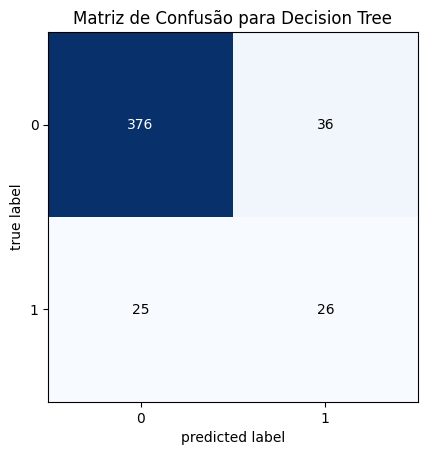

Relatório de classificação para Random Forest:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       412
           1       0.92      0.43      0.59        51

    accuracy                           0.93       463
   macro avg       0.93      0.71      0.78       463
weighted avg       0.93      0.93      0.92       463



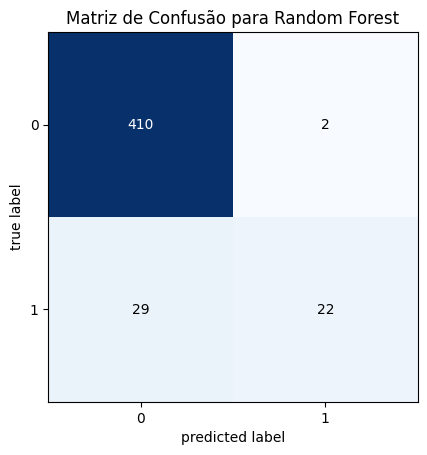

Relatório de classificação para AdaBoost:
              precision    recall  f1-score   support

           0       0.90      1.00      0.94       412
           1       0.75      0.06      0.11        51

    accuracy                           0.89       463
   macro avg       0.82      0.53      0.53       463
weighted avg       0.88      0.89      0.85       463



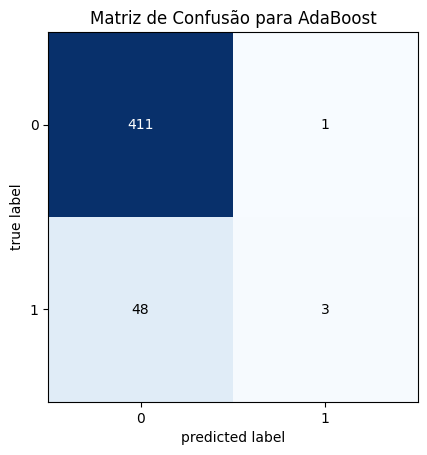

Relatório de classificação para GradientBoosting:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       412
           1       0.69      0.18      0.28        51

    accuracy                           0.90       463
   macro avg       0.80      0.58      0.61       463
weighted avg       0.88      0.90      0.87       463



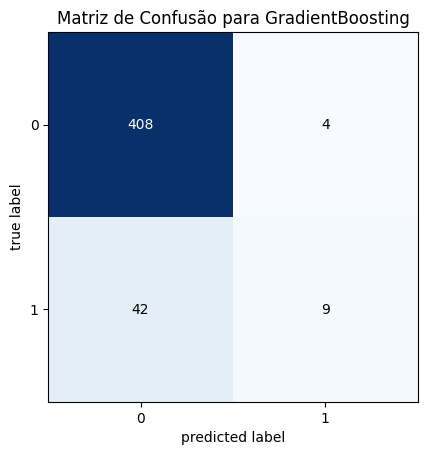

Relatório de classificação para XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       412
           1       0.74      0.49      0.59        51

    accuracy                           0.92       463
   macro avg       0.84      0.73      0.77       463
weighted avg       0.92      0.92      0.92       463



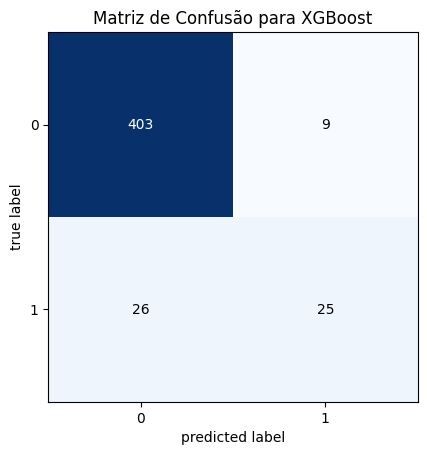

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110390 -> initscore=-2.086768
[LightGBM] [Info] Start training from score -2.086768
Relatório de classificação para LightGBM:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       412
           1       0.86      0.47      0.61        51

    accuracy                           0.93       463
   macro avg       0.90      0.73      0.79       463
weighted avg       0.93      0.93      0.92       463


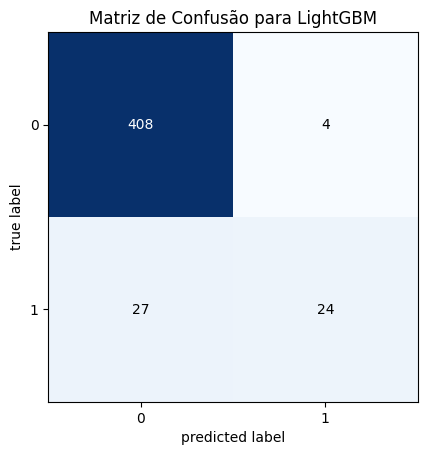

In [24]:
#usando a função analise_relatorio_matriz_confusao para observar os dados por meio da matriz confusão
analise_relatorio_matriz_confusao(lista_modelos, X_train, X_test, y_train, y_test)




 **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****

Modelo     : Decision Tree
Acurácia   : 0.86825
Precisão   : 0.88056
Revocação  : 0.86825
F1 - Score : 0.87377
ROC - AUC  : 0.71121


Modelo     : Random Forest
Acurácia   : 0.93305
Precisão   : 0.93204
Revocação  : 0.93305
F1 - Score : 0.92206
ROC - AUC  : 0.71326


Modelo     : AdaBoost
Acurácia   : 0.89417
Precisão   : 0.87941
Revocação  : 0.89417
F1 - Score : 0.85180
ROC - AUC  : 0.52820


Modelo     : GradientBoosting
Acurácia   : 0.90065
Precisão   : 0.88305
Revocação  : 0.90065
F1 - Score : 0.87334
ROC - AUC  : 0.58338


Modelo     : XGBoost
Acurácia   : 0.92441
Precisão   : 0.91691
Revocação  : 0.92441
F1 - Score : 0.91761
ROC - AUC  : 0.73418


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` 

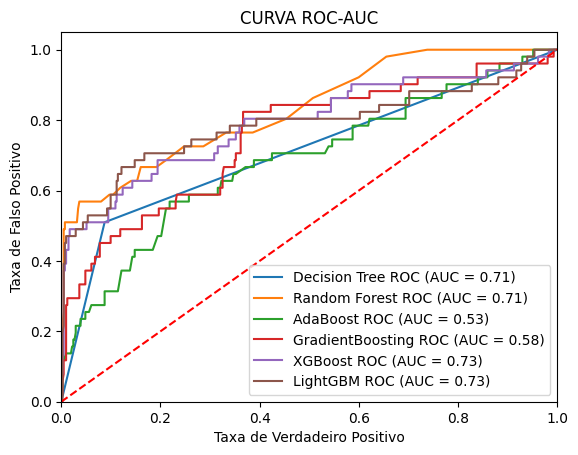

In [25]:
#usando a função nalise_curva_ROC_AUC para observar os dados por meio da curva ROC AUC
pipeline_resposta = analise_curva_ROC_AUC(lista_modelos, X_train, X_test, y_train, y_test)

In [26]:
#Organização dos modelos e métricas
metricas_df=dataframe_resposta(pipeline_resposta)
metricas_df

,modelo,Acurácia,Precisão,Revocação,f1_score,auc
0,Decision Tree,0.868251,0.880564,0.868251,0.873772,0.711213
1,Random Forest,0.933045,0.932038,0.933045,0.922056,0.713259
2,AdaBoost,0.894168,0.879406,0.894168,0.851805,0.528198
3,GradientBoosting,0.900648,0.883055,0.900648,0.873343,0.583381
4,XGBoost,0.924406,0.916912,0.924406,0.917611,0.734176
5,LightGBM,0.933045,0.929032,0.933045,0.924208,0.730440


#6 - Realizando a validação e otimização do modelo

## Validação do modelo 

A partir dos resultados das métricas dos modelos de classificação testados, ficou decidido que o modelo a ser utilizado será o LightGBM, tendo em vista seu melhor desempenho na métrica de Revocação, seguida pelo F1-Score. A escolha da métrica se deu em decorrência de optarmos por uma maior abrangência de clientes para recebimento do crédito.

#### Cross-Validation (Validação Cruzada)

A fim de medir a generalização do modelo optado, utilizarmos a técnica de validação cruzada. Dessa forma, saberemos o quão preciso é o nosso modelo, ou seja o seu desempenho em um novo conjunto de dados

Utilizando o _cross_val_score_:

In [27]:
# Criando uma instância do modelo LightGBM

model_chosen = lgb.LGBMClassifier(random_state=random_seed)

In [28]:
# Lista de métricas a serem avaliadas durante a validação cruzada
metrics = ['accuracy', 'recall', 'precision', 'f1']

# Realização da validação cruzada usando o modelo LightGBM
rf_cross_val = cross_validate(
    model_chosen,
    X_train_std, 
    y_train,
    scoring=metrics, 
    cv=5 
)

[LightGBM] [Info] Number of positive: 95, number of negative: 767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 884
[LightGBM] [Info] Number of data points in the train set: 862, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110209 -> initscore=-2.088610
[LightGBM] [Info] Start training from score -2.088610
[LightGBM] [Info] Number of positive: 95, number of negative: 767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 878
[LightGBM] [Info] Number of data points in the train set: 862, number of used features: 36
[LightGBM] [Info] [binary:BoostFro

In [29]:
pd.DataFrame(rf_cross_val)

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,0.065601,0.007775,0.916667,0.333333,0.800000,0.470588
1,0.061750,0.002461,0.907407,0.333333,0.666667,0.444444
2,0.059632,0.000000,0.925926,0.458333,0.785714,0.578947
3,0.067903,0.000000,0.925581,0.391304,0.818182,0.529412
4,0.062486,0.000000,0.939535,0.625000,0.789474,0.697674


In [30]:
pd.DataFrame(rf_cross_val).describe().T

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.063474,0.003273,0.059632,0.061750,0.062486,0.065601,0.067903
score_time,5.0,0.002047,0.003375,0.000000,0.000000,0.000000,0.002461,0.007775
test_accuracy,5.0,0.923023,0.011957,0.907407,0.916667,0.925581,0.925926,0.939535
test_recall,5.0,0.428261,0.121448,0.333333,0.333333,0.391304,0.458333,0.625000
test_precision,5.0,0.772007,0.060219,0.666667,0.785714,0.789474,0.800000,0.818182
test_f1,5.0,0.544213,0.100437,0.444444,0.470588,0.529412,0.578947,0.697674


Nota-se que nossos resultados foram bons, com a média da acurácia sendo 92% e a variância apenas 1%.

## Otimização do modelo

Agora, iremos verificar se com outras combinações de parâmetros é possível otimizar a performance do nosso modelo.

In [31]:
model_chosen.fit(X_train, y_train)
y_pred = model_chosen.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print(acc)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110390 -> initscore=-2.086768
[LightGBM] [Info] Start training from score -2.086768
0.9330453563714903


Vamos começar entendendo os principais parâmetros do modelo.

In [32]:
pprint("Parâmetros do LightGBM:")
pprint(model_chosen.get_params())

'Parâmetros do LightGBM:'
{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}


- boosting_type (string, default='gbdt'): Define o tipo de boosting a ser utilizado. 

- num_leaves (int, default=31): Número máximo de folhas em uma árvore. 

- learning_rate (float, default=0.1): Taxa de aprendizado ou step size, controla a contribuição de cada árvore para a atualização do modelo durante o treinamento.

- n_estimators (int, default=100): O número de árvores a serem treinadas.

- subsample (float, default=1.0): Fração de amostras a serem usadas para ajustar cada árvore. 

- colsample_bytree (float, default=1.0): Fração de características (colunas) a serem usadas para ajustar cada árvore.

- reg_alpha (float, default=0.0): Termo de regularização L1 nas folhas. Também conhecido como termo de penalização L1.

- reg_lambda (float, default=0.0): Termo de regularização L2 nas folhas. Também conhecido como termo de penalização L2.

In [33]:
# Definindo o espaço de pesquisa para os hiperparâmetros escolhidos
params_grid = {
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5], 
}


Partimos, agora, para o treinamento do GridSearch com os hiperparâmetros escolhidos para otimização.

In [36]:
grid_search = GridSearchCV(
    estimator=model_chosen, 
    param_grid = params_grid,
    scoring='accuracy',
    cv=3, 
    verbose=2,
    n_jobs=-1
)

In [37]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110390 -> initscore=-2.086768
[LightGBM] [Info] Start training from score -2.086768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'num_leaves': [20, 31, 40],
                         'reg_alpha': [0.0, 0.1, 0.5],
                         'reg_lambda': [0.0, 0.1, 0.5],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=2)

In [38]:
# Calculando a média dos resultados dos testes para todas as configurações de hiperparâmetros que foram experimentadas durante a pesquisa em grade 
print(grid_search.cv_results_['mean_test_score'].mean())

0.9060213789680645


Após a pesquisa em grade, vamos verificar o dicionário com os melhores valores de hiperparâmetros encontrados durante o processo de busca.

In [39]:
# Melhor parâmetro grid_search
grid_search.best_params_


{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'num_leaves': 40,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.8}

Verificando e analisando os resultados da pesquisa em grade ao criar um DataFrame contendo os resultados da validação cruzada e, em seguida, calcular estatísticas descritivas para esses resultados, facilitando a análise do desempenho do modelo em diferentes configurações de hiperparâmetros.

In [40]:
cvs = pd.DataFrame(grid_search.cv_results_)

cvs.T

,0,1,2,3,4,5,6,7,8,9,...,719,720,721,722,723,724,725,726,727,728
mean_fit_time,0.586819,0.635583,0.516913,0.451524,0.437882,0.400414,0.352741,0.337033,0.321802,0.324234,...,0.534326,0.505447,0.521914,0.601518,0.627068,0.568565,0.500428,0.503362,0.471429,0.361314
std_fit_time,0.083456,0.125432,0.03722,0.058945,0.000337,0.039791,0.010061,0.001933,0.006465,0.002672,...,0.013969,0.003437,0.007798,0.035935,0.002378,0.027277,0.000425,0.006773,0.014118,0.053057
mean_score_time,0.003546,0.004705,0.008883,0.007713,0.005695,0.003734,0.002454,0.006704,0.001112,0.002505,...,0.008102,0.00876,0.003354,0.004808,0.001854,0.003017,0.0,0.001733,0.009732,0.006463
std_score_time,0.00258,0.006654,0.006285,0.002037,0.004045,0.005281,0.001979,0.000846,0.001572,0.002553,...,0.004147,0.00187,0.004743,0.005869,0.000802,0.002158,0.0,0.001676,0.002977,0.002654
param_colsample_bytree,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
param_learning_rate,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
param_num_leaves,20,20,20,20,20,20,20,20,20,20,...,40,40,40,40,40,40,40,40,40,40
param_reg_alpha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,...,0.1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
param_reg_lambda,0.0,0.0,0.0,0.1,0.1,0.1,0.5,0.5,0.5,0.0,...,0.5,0.0,0.0,0.0,0.1,0.1,0.1,0.5,0.5,0.5
param_subsample,0.8,0.9,1.0,0.8,0.9,1.0,0.8,0.9,1.0,0.8,...,1.0,0.8,0.9,1.0,0.8,0.9,1.0,0.8,0.9,1.0


In [41]:
cvs.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_fit_time,729.0,0.466731,0.094866,0.305604,0.367625,0.481220,0.529583,0.929404
std_fit_time,729.0,0.013428,0.015213,0.000018,0.004432,0.007812,0.015990,0.126367
mean_score_time,729.0,0.004416,0.002481,0.000000,0.002522,0.004327,0.006192,0.013159
std_score_time,729.0,0.002986,0.001616,0.000000,0.001700,0.002973,0.004299,0.010500
split0_test_score,729.0,0.902218,0.009869,0.888889,0.888889,0.905556,0.911111,0.916667
split1_test_score,729.0,0.902003,0.011204,0.888579,0.891365,0.899721,0.908078,0.927577
split2_test_score,729.0,0.913844,0.018158,0.888579,0.888579,0.924791,0.927577,0.933148
mean_test_score,729.0,0.906021,0.012137,0.888683,0.889611,0.910949,0.915589,0.923014
std_test_score,729.0,0.006715,0.004732,0.000146,0.001247,0.006838,0.010711,0.017348
rank_test_score,729.0,330.851852,178.420066,1.000000,178.000000,361.000000,487.000000,697.000000


In [42]:
cvs.sort_values('rank_test_score').head().T

,473,472,471,195,197
mean_fit_time,0.532205,0.522268,0.525564,0.513726,0.516471
std_fit_time,0.004472,0.004455,0.010579,0.006316,0.001136
mean_score_time,0.003734,0.008438,0.006294,0.007736,0.010726
std_score_time,0.004581,0.005729,0.004588,0.004756,0.001297
param_colsample_bytree,0.9,0.9,0.9,0.8,0.8
param_learning_rate,0.1,0.1,0.1,0.1,0.1
param_num_leaves,40,40,40,31,31
param_reg_alpha,0.1,0.1,0.1,0.0,0.0
param_reg_lambda,0.1,0.1,0.1,0.5,0.5
param_subsample,1.0,0.9,0.8,0.8,1.0


In [43]:
cvs[cvs.rank_test_score == 1].sort_values('mean_fit_time').iloc[0].params

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'num_leaves': 40,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.9}

Treinando o modelo LGBMClassifier com os melhores parâmetros encontrados durante o __GridSearch__.

In [57]:
model_gs = lgb.LGBMClassifier(**grid_search.best_params_)

In [45]:
model_gs

LGBMClassifier(colsample_bytree=0.9, num_leaves=40, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.8)

In [46]:
model_gs.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110390 -> initscore=-2.086768
[LightGBM] [Info] Start training from score -2.086768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

LGBMClassifier(colsample_bytree=0.9, num_leaves=40, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.8)

In [47]:
y_pred_gs = model_gs.predict(X_test)

Calculamos, agora, a acurácia, a qual teve como resultado 0.93 aproximadamente, resultando em um bom resultado.

In [48]:
acc_grid = accuracy_score(y_test, y_pred_gs)
print(acc_grid)

0.9265658747300216


Agora, partiremos para a aplicação do __RandomizedSearchCV__, começando com o seu treinamento.

In [49]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=model_chosen,
    param_distributions=params_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [50]:
random_search.fit(X_train, y_train)
print(random_search.cv_results_['mean_test_score'].mean())

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110390 -> initscore=-2.086768
[LightGBM] [Info] Start training from score -2.086768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [51]:
# Verificando os melhores parâmetros após o treinamento
random_search.best_params_

{'subsample': 0.9,
 'reg_lambda': 0.1,
 'reg_alpha': 0.1,
 'num_leaves': 40,
 'learning_rate': 0.1,
 'colsample_bytree': 0.9}

Treinando o modelo LGBMClassifier com os melhores parâmetros encontrados durante o __RandomizedSearchCV__.

In [52]:
model_rs = lgb.LGBMClassifier(**random_search.best_params_)
model_rs

LGBMClassifier(colsample_bytree=0.9, num_leaves=40, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.9)

In [53]:
model_rs.fit(X_train, y_train)
y_pred_rs = model_rs.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119, number of negative: 959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1078, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110390 -> initscore=-2.086768
[LightGBM] [Info] Start training from score -2.086768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [55]:
# Salvando a acurácia com o RandomizedSearch
acc_random = accuracy_score(y_test, y_pred_rs)

In [56]:
# Realizando as comparações de acurácias
print("Comparação das Acurácias: ")
print('Acurácia sem Otimização:         ', np.round(acc, 3))
print('Acurácia com GridSearchCV:       ', np.round(acc_grid, 3))
print('Acurácia com RandomizedSearchCV: ', np.round(acc_random, 3))

Comparação das Acurácias: 
Acurácia sem Otimização:          0.933
Acurácia com GridSearchCV:        0.927
Acurácia com RandomizedSearchCV:  0.927


- No cenário sem otimização, o modelo alcançou uma acurácia de 0.933.
- No cenário com GridSearchCV, a acurácia é ligeiramente menor, indicando que os melhores parâmetros encontrados pela pesquisa em grade não resultaram em um modelo com desempenho melhor do que o modelo não otimizado.
- No cenário com RandomizedSearchCV, a acurácia é igual à do GridSearchCV, indicando que, no caso específico dos parâmetros testados pelo RandomizedSearchCV, ele não encontrou uma combinação melhor do que a encontrada pelo GridSearchCV.

Possíveis motivos:
- A acurácia é uma métrica simples e pode não ser suficiente para capturar completamente a qualidade do modelo;
- É importante considerar o tempo e os recursos computacionais necessários para a execução da pesquisa em grade ou busca aleatória.

Em resumo, ao comparar os resultados, deve-se levar em consideração não apenas as métricas de desempenho, mas também o contexto específico do problema, os recursos disponíveis e a relevância prática das melhorias alcançadas.